In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
         
    
from sklearn import datasets, linear_model, pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import recipe_helper
%aimport recipe_helper


# When to stop improving: the Bias/Variance tradeoff

In our Linear Regression model
we had great success when we created second order polynomial features.

We stopped adding features at order 2 because we achieved a perfect in-sample fit.

But if we hadn't: we would not worsen the in-sample fit by continuing to add higher order features.

So why not continue to add ?

Let's illustrate the problem: we'll use our first "linear" dataset, but corrupt one point.

This might occur, for example, because of a measurement error.

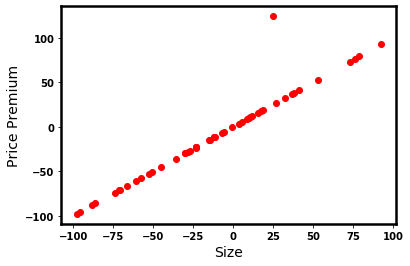

In [4]:
(xlabel, ylabel) = ("Size", "Price Premium")

v1, a1 = 1, .005
lin = recipe_helper.Recipe_Helper(v = v1, a = a1)
X_lin, y_lin = lin.gen_data(num=50)

bad = recipe_helper.Recipe_Helper(v = v1, a = 0)
X_bad, y_bad = bad.gen_data(num=50)

bad_idx = 0
bad.y[bad_idx] = bad.y[bad_idx] * 5
_ = bad.gen_plot(bad.X, bad.y, xlabel, ylabel)

<div class="alert alert-block alert-success">
<b>TIP</b>

- The time to discover a potential "problem" in the data is during Exploratory Data Analysis
- The time to *avoid* the problem is during Prepare the Data: Cleaning
    - We will show various ways to deal with suspect data
- For now: let's deal with the data as is 
</div>  

Let's fit a simple linear model (degree 1) and a more complex model (degree 7).

We will plot both out of sample (test) and in sample (train) data sets.

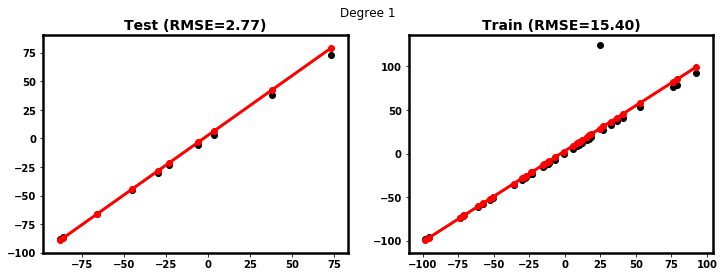

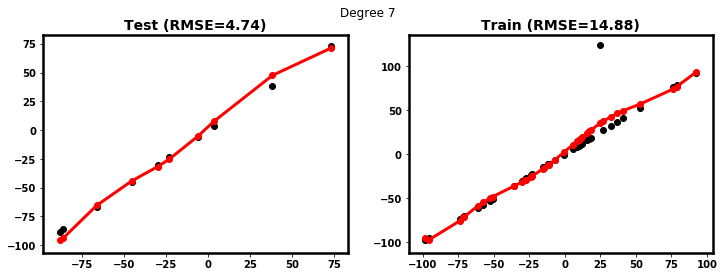

In [5]:
from sklearn.pipeline import make_pipeline

for degree in [1, 7]:
    poly_model = make_pipeline(PolynomialFeatures(degree),
                               linear_model.LinearRegression())

    fig, axs = bad.run_regress(bad.X, bad.y, model=poly_model, print_summary=False)
    _= fig.suptitle("Degree "+ str(degree))
       

In-sample (training) the Performance Metric decreases with increased model complexity.

But our ultimate goal, the out of sample Performance Metric, is worse.

The more complex model ignores the true linear relationship in a quest to match the training data.

If you add features, you might get a training fit which is better numerically but
also misses the essence.

Here is an even more extreme example: fitting a simple to describe function 
$$\cos( 1.5 * \pi * x )
$$
with a  polynomial of varying degree.


In [6]:
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

polynomial_features = PolynomialFeatures(include_bias=False)
linear_regression = linear_model.LinearRegression()
poly_pipe = pipeline.Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])

bvh = recipe_helper.Bias_vs_Variance_Helper(true_fun, poly_pipe)

_= bvh.create_data()

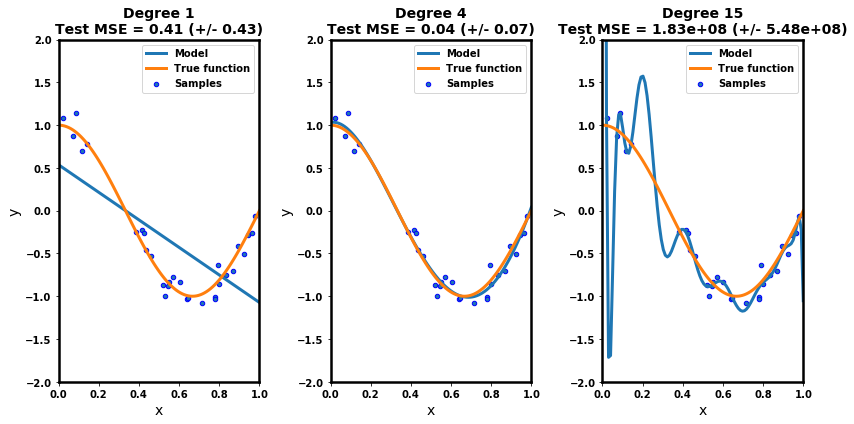

In [7]:
fig, axs = bvh.plot_degrees(degrees = [1, 4, 15])

- The degree 1 model is not powerful enough and "underfits" the True function.
    - You can see the fit (the blue line) to the actual function (orange line) is poor
    - So expect poor MSE on training and test (cross-validation) examples
- The degree 4 model fit looks much better: notice the decrease in the cross-validation MSE in the title
- The degree 15 model is *too* powerful and "overfits" the True function
    - it fits most of the points, but generalizes poorly, as seen in the cross-validation MSE

If we plot the training and test MSE's, versus degree of the polynomial, the story becomes clear

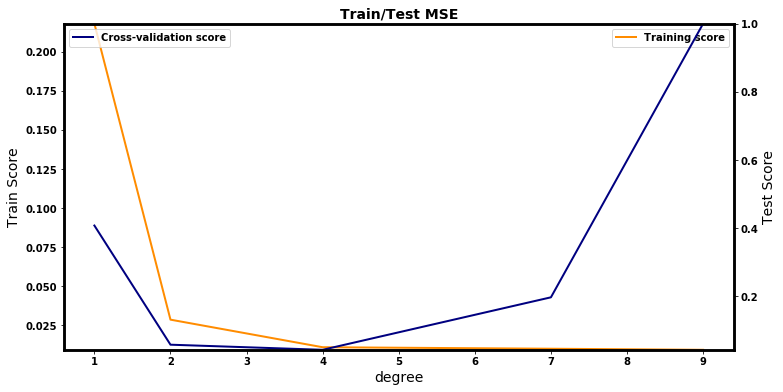

In [8]:
fig, axs = bvh.plot_validation_curve(degrees=[1, 2, 4, 7, 9])

- Training MSE decreases as degree increases
- Test MSE decreases *to a point* and then shoots up
    - the actual graph is worse: we clipped the test MSE to a maximum of 1 (true MSE at degree 15 is 10e8 !)

By adding more features, we can improve the in-sample Performance Metric
- eventually we can "memorize" the training set
- but out of sample generalization would likely suffer
- this is called *overfitting* or *high variance*

Alternatively, we might find the out of sample Performance Metric better than in-sample!
- this indicates that there is unrealized potential in the training data
- this is called *underfitting* or *high bias*


*Overfitting* is a problem because it means that $\Theta$ has been made overly sensitive to the training examples.

It is unlikely to generalize (i.e., predict out of sample) well.

*Underfitting* is a problem because it means your model may be able to be improved

Let's see how to determine whether we have an overfitting or underfitting problem.


We can quantify these concepts in terms of the relationship between the Training Error and the Validation Error.

## High Variance
- if Training Error $<<$ Validation Error
    - overfit: poor generalization out of sample
        - model may be too complex relative to quantity of Training Data
            - simplify model (fewer parameters)
            - use regularization to reduce number of non-zero parameters
            - increase Training Data (e.g., data augmentation)

## High Bias
- if Training Error $>$ Validation Error or Training Error seems "high"
    - underfit: sub-optimal performance in sample
        - try a more complex (more parameters) model
        - train model longer (assuming optimization via search, rather than closed form solution)
        - what is "high" ? Compare to a baseline model

## Regularization: reducing overfitting
What can we do to combat over-fitting ?

Recall that LinearRegression model is optimizing a Loss Function $\loss$
which was initially identical to the performance metric MSE in our example.

We will create a *weighted penalty* term 

$$P = \alpha Q$$
where $Q$ is a function of $\Theta$ in order to impose a cost on using too many degrees of freedom.

The new loss function becomes
$$
\loss' = \loss + \alpha Q
$$

The weight $\alpha$ balances the original Loss function with the penalty.

Observe that the new Loss function is **no longer identical** to the performance metric, which
remains unchanged.

We'll show several modified Regression models and identify the penalty used.

### [Ridge Regression](PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Ridge-regression-%28$L_2$-Regularization%29)

Penalty is: sum (over parameters) of squared parameter value

$$
Q = \sum_{n=1}^N \theta_n^2
$$

Also known as $L_2$ regularizer.

This tends to push parameters $\theta_n$ towards smaller values.

### [Lasso Regression][1]
[1]: PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Lasso-regression-($L_1$-regularization)


Penalty is: sum (over parameters) of parameter's absolute value
$$
Q = \sum_{n=1}^N |\theta_n|
$$

Also know as the $L_1$ regularizer.

This tends to push parameters $\theta_n$ towards 0

<div class="alert alert-block alert-success">
    <b>TIP</b> 

- Know your Loss Function !  
    - This is what is driving your model's fitting process.  Does it make sense for your problem ?

- Don't try to force a square peg into a round hole.
</div>


The strength of the regularization penalty $\alpha$ is a *hyper-parameter*
- Can be fine-tuned

In [9]:
print("Done !")

Done !
